# EDA

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import json
import os
# This is so progress apply will work which will tell us how far we are in our df.apply()
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
train = pd.read_csv(r"C:\repo\math4920\ASLKaggleProject\asl-signs\train.csv")
parquet_file_path = r"C:\repo\math4920\ASLKaggleProject\asl-signs\train_landmark_files\16069\10042041.parquet"
xyz = pd.read_parquet(r"C:\repo\math4920\ASLKaggleProject\asl-signs\train_landmark_files\16069\10042041.parquet")
# Here we are going to look at an example sign for 'green'
train.query('sequence_id == 10042041')

,path,participant_id,sequence_id,sign
101,train_landmark_files/16069/10042041.parquet,16069,10042041,green


![SegmentLocal](https://www.lifeprint.com/asl101/gifs-animated/green.gif "green")

In [3]:
# This is what one parquet file looks like in df
# for each row it contains what landmark mediapipe noticed (face, hand, pose, etc)
# for those unfamiliar with ASL facial expressions can be used for emphasis + expression, etc.
# at what frame in the sequence and the x,y,z coordinates of the landmark
xyz

,frame,row_id,type,landmark_index,x,y,z
0,83,83-face-0,face,0,0.387253,0.381374,-0.051682
1,83,83-face-1,face,1,0.373218,0.342151,-0.070351
2,83,83-face-2,face,2,0.378215,0.357100,-0.043825
3,83,83-face-3,face,3,0.368546,0.311701,-0.041492
4,83,83-face-4,face,4,0.373314,0.330986,-0.071895
...,...,...,...,...,...,...,...
57010,187,187-right_hand-16,right_hand,16,NaN,NaN,NaN
57011,187,187-right_hand-17,right_hand,17,NaN,NaN,NaN
57012,187,187-right_hand-18,right_hand,18,NaN,NaN,NaN
57013,187,187-right_hand-19,right_hand,19,NaN,NaN,NaN


In [4]:
# just for this one sign we have 57,000 rows!
xyz.shape

(57015, 7)

In [5]:
# but that consists of multiple rows about each frame
xyz['frame'].value_counts()
# for each frame we have 543 features

83     543
136    543
160    543
159    543
158    543
      ... 
115    543
114    543
113    543
112    543
187    543
Name: frame, Length: 105, dtype: int64

In [6]:
xyz.query('frame == 83')

,frame,row_id,type,landmark_index,x,y,z
0,83,83-face-0,face,0,0.387253,0.381374,-0.051682
1,83,83-face-1,face,1,0.373218,0.342151,-0.070351
2,83,83-face-2,face,2,0.378215,0.357100,-0.043825
3,83,83-face-3,face,3,0.368546,0.311701,-0.041492
4,83,83-face-4,face,4,0.373314,0.330986,-0.071895
...,...,...,...,...,...,...,...
538,83,83-right_hand-16,right_hand,16,NaN,NaN,NaN
539,83,83-right_hand-17,right_hand,17,NaN,NaN,NaN
540,83,83-right_hand-18,right_hand,18,NaN,NaN,NaN
541,83,83-right_hand-19,right_hand,19,NaN,NaN,NaN


In [7]:
# This comes from the Kaggle competition details and is how they expect the data to be loaded in
ROWS_PER_FRAME = 543  # number of landmarks per frame

# this pivots the data so it's frame by point by xyz
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [8]:
# now we have our xyz in numpy format
xyz_np = load_relevant_data_subset(parquet_file_path)
xyz_np.shape

(105, 543, 3)

In [9]:
# we are going to test this as input to our first baseline model we made
# if you have problems with it saying you're maybe using an old tf_lite binary on a new model with the tflite_runtime
# code you see online, use this below code instead
interpreter = tf.lite.Interpreter(r"C:\repo\math4920\ASLKaggleProject\models\asl_model\model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

<AxesSubplot: >

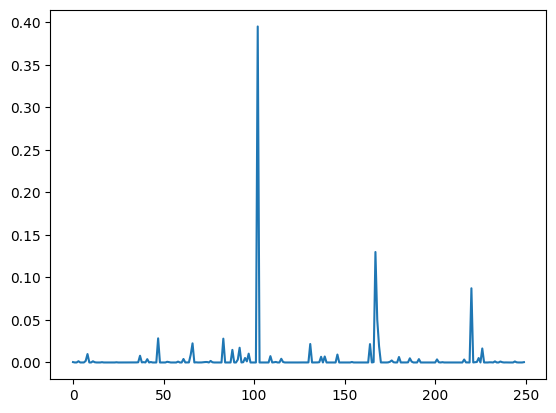

In [10]:
# now we have a prediction function we can put input data into!
prediction = prediction_fn(inputs=xyz_np)
# this is a dictionary with key 'outputs'
# with len 250 which is the number of signs we're trying to predict
prediction['outputs'].shape
# we can plot the panda series of it to see that there is one that is spiking!
pd.Series(prediction['outputs']).plot()

In [11]:
# this gives us the location of the one that is spiked
sign = prediction['outputs'].argmax()
# we need a function to turn this number into the sign's word representation
train['sign_ord'] = train['sign'].astype('category').cat.codes
# TIL: squeeze removes single dimensional entries from an array
# https://tinyurl.com/zhu5v53k
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

# YAY! We got it right!
ORD2SIGN[sign]

'green'

In [12]:
xyz.query('frame == 83')['type'].value_counts()

face          468
pose           33
left_hand      21
right_hand     21
Name: type, dtype: int64

# Baseline Model

### Helper Functions
Some nice and convenient helper functions the kind kagglers of the world have made publicly available in the notebooks section

In [13]:
def flatten_l_o_l(nested_list):
    """Flatten a list of lists into a single list.

    Args:
        nested_list (list): 
            – A list of lists (or iterables) to be flattened.

    Returns:
        list: A flattened list containing all items from the input list of lists.
    """
    return [item for sublist in nested_list for item in sublist]


def print_ln(symbol="-", line_len=110, newline_before=False, newline_after=False):
    """Print a horizontal line of a specified length and symbol.

    Args:
        symbol (str, optional): 
            – The symbol to use for the horizontal line
        line_len (int, optional): 
            – The length of the horizontal line in characters
        newline_before (bool, optional): 
            – Whether to print a newline character before the line
        newline_after (bool, optional): 
            – Whether to print a newline character after the line
    """
    if newline_before: print();
    print(symbol * line_len)
    if newline_after: print();
        
        
def read_json_file(file_path):
    """Read a JSON file and parse it into a Python object.

    Args:
        file_path (str): The path to the JSON file to read.

    Returns:
        dict: A dictionary object representing the JSON data.
        
    Raises:
        FileNotFoundError: If the specified file path does not exist.
        ValueError: If the specified file path does not contain valid JSON data.
    """
    try:
        # Open the file and load the JSON data into a Python object
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        return json_data
    except FileNotFoundError:
        # Raise an error if the file path does not exist
        raise FileNotFoundError(f"File not found: {file_path}")
    except ValueError:
        # Raise an error if the file does not contain valid JSON data
        raise ValueError(f"Invalid JSON data in file: {file_path}")
        
def get_sign_df(pq_path, invert_y=True):
    sign_df = pd.read_parquet(pq_path)
    
    # y value is inverted (Thanks @danielpeshkov)
    if invert_y: sign_df["y"] *= -1 
        
    return sign_df

def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

### Load Data

In [14]:
# Define the path to the root data directory
DATA_DIR         = str(os.getcwd()) + r"\asl-signs"
# this notebook joins together and aggregates some features into this 'extended' dataset
EXTEND_TRAIN_PATH = r"C:\repo\math4920\ASLKaggleProject\asl-signs\extended_train.csv" 

# this should be true if you've already constructed the extended_train.csv file
LOAD_EXTENDED = True
if LOAD_EXTENDED:
    train_df = pd.read_csv(EXTEND_TRAIN_PATH)
else:
    train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
    train_df["path"] = DATA_DIR+"\\"+train_df["path"]
display(train_df)
# should be 94,477 rows for each sign event

,path,participant_id,sequence_id,sign,start_frame,end_frame,total_frames,face_count,face_nan_count,pose_count,pose_nan_count,left_hand_count,left_hand_nan_count,right_hand_count,right_hand_nan_count,x_min,x_max,y_min,y_max,z_min,z_max,face_appears_pct,face_nan_pct,left_hand_appears_pct,left_hand_nan_pct,pose_appears_pct,pose_nan_pct,right_hand_appears_pct,right_hand_nan_pct
0,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,26734,1000035562,blow,20,42,23,10764,0,759,0,483,483,483,252,-0.031811,1.294350,-2.147826,-0.224151,-2.782624,1.910815,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.521739
1,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,28656,1000106739,wait,29,39,11,5148,0,363,0,231,231,231,189,-0.017062,1.015931,-2.222732,-0.329273,-2.543970,1.627621,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.818182
2,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,16069,100015657,cloud,103,207,105,49140,0,3465,0,2205,1617,2205,2205,-0.042923,1.197836,-2.591290,-0.248094,-2.838325,1.587503,1.0,0.0,1.0,0.733333,1.0,0.0,1.0,1.000000
3,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,25571,1000210073,bird,17,28,12,5616,0,396,0,252,252,252,0,-0.129268,1.156573,-2.294936,-0.310272,-3.018237,2.196296,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.000000
4,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,62590,1000240708,owie,22,39,18,8424,0,594,0,378,378,378,0,0.072425,1.165405,-2.264609,-0.405282,-2.970331,1.360011,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,53618,999786174,white,64,112,49,22932,0,1617,0,1029,1029,1029,546,0.031721,1.183957,-2.561170,-0.297828,-3.287074,2.400607,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.530612
94473,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,26734,999799849,have,36,41,6,2808,0,198,0,126,126,126,84,-0.149159,1.310044,-2.170514,-0.177696,-2.678213,1.494088,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.666667
94474,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,25571,999833418,flower,1,37,37,17316,0,1221,0,777,777,777,294,0.057847,0.977379,-2.460778,-0.223186,-3.220553,2.083376,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.378378
94475,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,29302,999895257,room,9,42,34,15912,0,1122,0,714,714,714,588,-0.045806,0.985802,-2.081611,-0.325751,-2.036529,2.350194,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.823529


### Data / Feature Engineering

In [15]:
subsample_train_df = train_df.copy()
display(subsample_train_df)

,path,participant_id,sequence_id,sign,start_frame,end_frame,total_frames,face_count,face_nan_count,pose_count,pose_nan_count,left_hand_count,left_hand_nan_count,right_hand_count,right_hand_nan_count,x_min,x_max,y_min,y_max,z_min,z_max,face_appears_pct,face_nan_pct,left_hand_appears_pct,left_hand_nan_pct,pose_appears_pct,pose_nan_pct,right_hand_appears_pct,right_hand_nan_pct
0,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,26734,1000035562,blow,20,42,23,10764,0,759,0,483,483,483,252,-0.031811,1.294350,-2.147826,-0.224151,-2.782624,1.910815,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.521739
1,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,28656,1000106739,wait,29,39,11,5148,0,363,0,231,231,231,189,-0.017062,1.015931,-2.222732,-0.329273,-2.543970,1.627621,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.818182
2,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,16069,100015657,cloud,103,207,105,49140,0,3465,0,2205,1617,2205,2205,-0.042923,1.197836,-2.591290,-0.248094,-2.838325,1.587503,1.0,0.0,1.0,0.733333,1.0,0.0,1.0,1.000000
3,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,25571,1000210073,bird,17,28,12,5616,0,396,0,252,252,252,0,-0.129268,1.156573,-2.294936,-0.310272,-3.018237,2.196296,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.000000
4,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,62590,1000240708,owie,22,39,18,8424,0,594,0,378,378,378,0,0.072425,1.165405,-2.264609,-0.405282,-2.970331,1.360011,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,53618,999786174,white,64,112,49,22932,0,1617,0,1029,1029,1029,546,0.031721,1.183957,-2.561170,-0.297828,-3.287074,2.400607,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.530612
94473,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,26734,999799849,have,36,41,6,2808,0,198,0,126,126,126,84,-0.149159,1.310044,-2.170514,-0.177696,-2.678213,1.494088,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.666667
94474,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,25571,999833418,flower,1,37,37,17316,0,1221,0,777,777,777,294,0.057847,0.977379,-2.460778,-0.223186,-3.220553,2.083376,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.378378
94475,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,29302,999895257,room,9,42,34,15912,0,1122,0,714,714,714,588,-0.045806,0.985802,-2.081611,-0.325751,-2.036529,2.350194,1.0,0.0,1.0,1.000000,1.0,0.0,1.0,0.823529


In [16]:
# this functions aggregates the data up to the level of one row = one sign event
# This cell will take awhile if LOAD_EXTENDED = False
def get_seq_meta(row, invert_y=True, do_counts=False):
    """Calculates and adds metadata to the given row of sign language event data.
    
    Args:
        row (pandas.core.series.Series): A row of sign language event data containing columns:
            path: The file path to the Parquet file containing the landmark data for the event.
        invert_y (bool, optional): Whether to invert the y-coordinate of each landmark. Defaults to True.
    
    Returns:
        pandas.core.series.Series: The input row with added metadata columns:
            start_frame: The frame number of the first frame in the event.
            end_frame: The frame number of the last frame in the event.
            total_frames: The number of frames in the event.
            face_count: The number of landmarks in the 'face' type. [optional]
            pose_count: The number of landmarks in the 'pose' type. [optional]
            left_hand_count: The number of landmarks in the 'left_hand' type. [optional]
            right_hand_count: The number of landmarks in the 'right_hand' type. [optional]
            x_min: The minimum x-coordinate value of any landmark in the event.
            x_max: The maximum x-coordinate value of any landmark in the event.
            y_min: The minimum y-coordinate value of any landmark in the event.
            y_max: The maximum y-coordinate value of any landmark in the event.
            z_min: The minimum z-coordinate value of any landmark in the event.
            z_max: The maximum z-coordinate value of any landmark in the event.
    """
    # Extract the sign language event data from the Parquet file at the given path
    df = get_sign_df(row['path'], invert_y=invert_y)
    
    # Count the number of landmarks in each type
    type_counts = df['type'].value_counts(dropna=False).to_dict()
    nan_counts  = df.groupby("type")["x"].apply(lambda x: x.isna().sum())
    
    # Calculate metadata for the event and add it to the input row
    row['start_frame'] = df['frame'].min()
    row['end_frame'] = df['frame'].max()
    row['total_frames'] = df['frame'].nunique()
    
    if do_counts:
        for _type in ["face", "pose", "left_hand", "right_hand"]:
            row[f'{_type}_count'] = type_counts[_type]
            row[f'{_type}_nan_count'] = nan_counts[_type]
        
    for coord in ['x', 'y', 'z']:
        row[f'{coord}_min'] = df[coord].min()
        row[f'{coord}_max'] = df[coord].max()
    
    return row

type_kp_map = dict(face=468, left_hand=21, pose=33, right_hand=21)
col_order = [
    'path', 'participant_id', 'sequence_id', 'sign', 'start_frame', 'end_frame', 'total_frames', 
    'face_nan_count', 'face_nan_pct', 'left_hand_nan_count', 'left_hand_nan_pct', 'pose_nan_count', 'pose_nan_pct',
    'right_hand_nan_count', 'right_hand_nan_pct', 'x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max',
]

# I've already ran this and constructed my aggregated data
LOAD_EXTENDED = True
if not LOAD_EXTENDED:
    # Will take around 5-10 minutes on subsample and around 50-100 minutes on the full dataset
    subsample_train_df = subsample_train_df.progress_apply(lambda x: get_seq_meta(x, do_counts=True), axis=1)
    for _type, _count in type_kp_map.items():
        subsample_train_df[f"{_type}_appears_pct"] = subsample_train_df[f"{_type}_count"]/(subsample_train_df[f"total_frames"]*_count)
        subsample_train_df[f"{_type}_nan_pct"]     = subsample_train_df[f"{_type}_nan_count"]/(subsample_train_df[f"total_frames"]*_count)
    # Extended save for later...
    subsample_train_df.to_csv("asl-signs/extended_train.csv", index=False)
    display(subsample_train_df)
else:
    # del subsample_train_df
    for _type, _count in type_kp_map.items():
            train_df[f"{_type}_appears_pct"] = train_df[f"{_type}_count"]/(train_df[f"total_frames"]*_count)
            train_df[f"{_type}_nan_pct"]     = train_df[f"{_type}_nan_count"]/(train_df[f"total_frames"]*_count)
    train_df = train_df[col_order]
    display(train_df)

,path,participant_id,sequence_id,sign,start_frame,end_frame,total_frames,face_nan_count,face_nan_pct,left_hand_nan_count,left_hand_nan_pct,pose_nan_count,pose_nan_pct,right_hand_nan_count,right_hand_nan_pct,x_min,x_max,y_min,y_max,z_min,z_max
0,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,26734,1000035562,blow,20,42,23,0,0.0,483,1.000000,0,0.0,252,0.521739,-0.031811,1.294350,-2.147826,-0.224151,-2.782624,1.910815
1,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,28656,1000106739,wait,29,39,11,0,0.0,231,1.000000,0,0.0,189,0.818182,-0.017062,1.015931,-2.222732,-0.329273,-2.543970,1.627621
2,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,16069,100015657,cloud,103,207,105,0,0.0,1617,0.733333,0,0.0,2205,1.000000,-0.042923,1.197836,-2.591290,-0.248094,-2.838325,1.587503
3,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,25571,1000210073,bird,17,28,12,0,0.0,252,1.000000,0,0.0,0,0.000000,-0.129268,1.156573,-2.294936,-0.310272,-3.018237,2.196296
4,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,62590,1000240708,owie,22,39,18,0,0.0,378,1.000000,0,0.0,0,0.000000,0.072425,1.165405,-2.264609,-0.405282,-2.970331,1.360011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,53618,999786174,white,64,112,49,0,0.0,1029,1.000000,0,0.0,546,0.530612,0.031721,1.183957,-2.561170,-0.297828,-3.287074,2.400607
94473,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,26734,999799849,have,36,41,6,0,0.0,126,1.000000,0,0.0,84,0.666667,-0.149159,1.310044,-2.170514,-0.177696,-2.678213,1.494088
94474,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,25571,999833418,flower,1,37,37,0,0.0,777,1.000000,0,0.0,294,0.378378,0.057847,0.977379,-2.460778,-0.223186,-3.220553,2.083376
94475,C:\repo\math4920\ASLKaggleProject\asl-signs\tr...,29302,999895257,room,9,42,34,0,0.0,714,1.000000,0,0.0,588,0.823529,-0.045806,0.985802,-2.081611,-0.325751,-2.036529,2.350194


### Create TFRecords
TFRecords are tensorflow's custom binary data format, that help with dealing with the size of data we have here. It is read more efficiently from disk and only uses a batch at a time, meaning we don't have to store all ~50gb in memory.

In [17]:
class CFG:
    data_path = r'C:\repo\math4920\ASLKaggleProject\asl-signs\\'
    sequence_length = 12
    rows_per_frame = 543 

In [18]:
# a version of the load data function kaggle gives us that replaces NaN with zero
def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

train = pd.read_csv(r"C:\repo\math4920\ASLKaggleProject\asl-signs\train.csv")
label_index = read_json_file(r"C:\repo\math4920\ASLKaggleProject\asl-signs\sign_to_prediction_index_map.json")
index_label = dict([(label_index[key], key) for key in label_index])
print(label_index)
train["label"] = train["sign"].map(lambda sign: label_index[sign])
train.head()

{'TV': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, 'fall': 74, 'farm': 75, 'fast': 76, 'feet': 77, 'find': 78, '

,path,participant_id,sequence_id,sign,label
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


In [19]:
def create_record(feature, label):
    dic = {}
    dic["feature"] = tf.train.Feature(float_list=tf.train.FloatList(value=feature))
    dic["label"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    record_bytes = tf.train.Example(features=tf.train.Features(feature=dic)).SerializeToString()
    return record_bytes
    
def decode_function(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "feature": tf.io.FixedLenFeature([CFG.sequence_length * CFG.rows_per_frame * 3], dtype=tf.float32),
          "label": tf.io.FixedLenFeature([], dtype=tf.int64)
      }
  )

In [20]:
# This can take a long time so skip if you've already done it once
CREATE_RECORDS = False

cwd = os.getcwd() + r"\asl-signs\tfrecords\\"

if CREATE_RECORDS:
    for participant_id in train.participant_id.unique():
        df = train[train.participant_id == participant_id]
        save_path = f"{cwd}{participant_id}.tfrecords"
        print(save_path)
        with tf.io.TFRecordWriter(save_path) as file_writer:
            for i in tqdm(range(len(df))):
                path = f"{CFG.data_path}{df.iloc[i].path}"
                feature = load_relevant_data_subset_with_imputation(path)
                feature = tf.image.resize(tf.constant(feature), (CFG.sequence_length, 543)).numpy().reshape(-1)
                label = int(df.iloc[i].label)
                file_writer.write(create_record(feature, label))

### Baseline Attempt

In [26]:
cwd = os.getcwd()
# this data comes from another kaggle notebook output
train_x    = np.load(r"C:\repo\math4920\ASLKaggleProject\asl-signs\gislr-feature-data\feature_data.npy").astype(np.float32)
train_y    = np.load(r"C:\repo\math4920\ASLKaggleProject\asl-signs\gislr-feature-data\feature_labels.npy").astype(np.uint8)
BATCH_SIZE = 64

N_TOTAL = train_x.shape[0]
VAL_PCT = 0.1
N_VAL   = int(N_TOTAL*VAL_PCT)
N_TRAIN = N_TOTAL-N_VAL

random_idxs = random.sample(range(N_TOTAL), N_TOTAL)
train_idxs, val_idxs = np.array(random_idxs[:N_TRAIN]), np.array(random_idxs[N_TRAIN:])

val_x, val_y = train_x[val_idxs], train_y[val_idxs]
train_x, train_y = train_x[train_idxs], train_y[train_idxs]

In [27]:
def fc_block(inputs, output_channels, dropout=0.2):
    x = tf.keras.layers.Dense(output_channels)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x

def get_model(n_labels=250, init_fc=512, n_blocks=2, _dropout_1=0.2, _dropout_2=0.6, flat_frame_len=3258):
    _inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
    x = _inputs
    
    # Define layers
    for i in range(n_blocks):
        x = fc_block(
            x, output_channels=init_fc//(2**i), 
            dropout=_dropout_1 if (1+i)!=n_blocks else _dropout_2
        )
    
    # Define output layer
    _outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)
    
    # Build the model
    model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
    return model

model = get_model()
model.compile(tf.keras.optimizers.Adam(0.000333), "sparse_categorical_crossentropy", metrics="acc")
model.summary()

tf.keras.utils.plot_model(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3258)]            0         
                                                                 
 dense (Dense)               (None, 512)               1668608   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [ ]:
# WARNING: Model fitting here will also take awhile 
cb_list = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.8, verbose=1)
]
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=100, callbacks=cb_list, batch_size=BATCH_SIZE)
# model.save("./models/asl_model")

Epoch 1/100
1329/1329 [==============================] - 24s 17ms/step - loss: 5.3707 - acc: 0.0146 - val_loss: 5.2390 - val_acc: 0.0187 - lr: 3.3300e-04
Epoch 2/100
1329/1329 [==============================] - 24s 18ms/step - loss: 4.5584 - acc: 0.0637 - val_loss: 4.9709 - val_acc: 0.0281 - lr: 3.3300e-04
Epoch 3/100
1329/1329 [==============================] - 24s 18ms/step - loss: 3.9586 - acc: 0.1287 - val_loss: 4.6137 - val_acc: 0.0626 - lr: 3.3300e-04
Epoch 4/100
1329/1329 [==============================] - 25s 19ms/step - loss: 3.6219 - acc: 0.1743 - val_loss: 4.3904 - val_acc: 0.0923 - lr: 3.3300e-04
Epoch 5/100
1329/1329 [==============================] - 24s 18ms/step - loss: 3.4130 - acc: 0.2144 - val_loss: 4.7804 - val_acc: 0.0555 - lr: 3.3300e-04
Epoch 6/100
1328/1329 [============================>.] - ETA: 0s - loss: 3.2544 - acc: 0.2429
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000266400002874434.
1329/1329 [==============================] - 23s 17ms/step - 

Epoch 45/100
1329/1329 [==============================] - 25s 19ms/step - loss: 1.9802 - acc: 0.5081 - val_loss: 1.8467 - val_acc: 0.5500 - lr: 4.4695e-05
Epoch 46/100
1329/1329 [==============================] - 26s 19ms/step - loss: 1.9677 - acc: 0.5102 - val_loss: 1.8369 - val_acc: 0.5537 - lr: 4.4695e-05
Epoch 47/100
1329/1329 [==============================] - 25s 19ms/step - loss: 1.9693 - acc: 0.5081 - val_loss: 1.9087 - val_acc: 0.5346 - lr: 4.4695e-05
Epoch 48/100
1328/1329 [============================>.] - ETA: 0s - loss: 1.9661 - acc: 0.5101
Epoch 48: ReduceLROnPlateau reducing learning rate to 3.575560112949461e-05.
1329/1329 [==============================] - 25s 19ms/step - loss: 1.9663 - acc: 0.5100 - val_loss: 2.0163 - val_acc: 0.4950 - lr: 4.4695e-05
Epoch 49/100
1329/1329 [==============================] - 25s 19ms/step - loss: 1.9472 - acc: 0.5140 - val_loss: 1.7719 - val_acc: 0.5702 - lr: 3.5756e-05
Epoch 50/100
1329/1329 [==============================] - 25s 19ms

In [ ]:
# needed for conversion into TFLite
# this below code for going from tensorflow to TFLite also provided by nice Kagglers
class PrepInputs(tf.keras.layers.Layer):
    def __init__(self, face_idx_range=(0, 468), lh_idx_range=(468, 489), 
                 pose_idx_range=(489, 522), rh_idx_range=(522, 543)):
        super(PrepInputs, self).__init__()
        self.idx_ranges = [face_idx_range, lh_idx_range, pose_idx_range, rh_idx_range]
        self.flat_feat_lens = [3*(_range[1]-_range[0]) for _range in self.idx_ranges]
    
    def call(self, x_in):
        
        # Split the single vector into 4
        xs = [x_in[:, _range[0]:_range[1], :] for _range in self.idx_ranges]
        
        # Reshape based on specific number of keypoints
        xs = [tf.reshape(_x, (-1, flat_feat_len)) for _x, flat_feat_len in zip(xs, self.flat_feat_lens)]
        
        # Drop empty rows - Empty rows are present in 
        #   --> pose, lh, rh
        #   --> so we don't have to for face
        xs[1:] = [
            tf.boolean_mask(_x, tf.reduce_all(tf.logical_not(tf.math.is_nan(_x)), axis=1), axis=0)
            for _x in xs[1:]
        ]
        
        # Get means and stds
        x_means = [tf.math.reduce_mean(_x, axis=0) for _x in xs]
        x_stds  = [tf.math.reduce_std(_x,  axis=0) for _x in xs]
        
        x_out = tf.concat([*x_means, *x_stds], axis=0)
        x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
        return tf.expand_dims(x_out, axis=0)
    
PrepInputs()(load_relevant_data_subset(train_df.path[0]))

In [ ]:
class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ISLR model 
    """

    def __init__(self, islr_model):
        """
        Initializes the TFLiteModel with the specified preprocessing model and ISLR model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = PrepInputs()
        self.islr_model   = islr_model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        outputs = self.islr_model(x)[0, :]

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

tflite_keras_model = TFLiteModel(islr_model=model)
demo_output = tflite_keras_model(load_relevant_data_subset(train_df.path[0]))["outputs"]
ORD2SIGN[np.argmax(demo_output.numpy(), axis=-1)]

In [ ]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
tflite_model = keras_model_converter.convert()
with open(r'C:\repo\math4920\ASLKaggleProject\kaggle\working\models\model.tflite', 'wb') as f:
    f.write(tflite_model)
# !zip submission.zip /kaggle/working/models/model.tflite


import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/working/models/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
# if REQUIRED_SIGNATURE not in found_signatures:
#     raise KernelEvalException('Required input signature not found.')
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=load_relevant_data_subset(train_df.path[0]))
sign = np.argmax(output["outputs"])

print("PRED : ", ORD2SIGN[sign])
print("GT   : ", train_df.sign[0])

### Possible Extensions
Others' data analysis has shown there is typically only one hand present, so we could build separate left and right hand models.

Could try some other more basic models like XGBOOST on the dataset above, althoug deep learning seems to be the common approach here.

Other Kagglers on top of LB suggest Label Smoothing for CE?

### Sources
Followed along with this video to learn about the data:
https://www.youtube.com/live/L-IaQch8KYY?feature=share

Followed this notebook to get a start on a baseline model:
https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline

Followed this notebook to create the tfrecords:
https://www.kaggle.com/code/lonnieqin/islr-create-tfrecord